# Part 2: Figure 7D

In [1]:
'''
Run BatchRun.py, which is stored in test/BatchRun.py to process multiple Edman rounds for the mycoplasma proteome.
'''

!python test/BatchRun.py

Adaptive Monte Carlo batch (two-phase, subfolder version): 132 total conditions.

Performing global fragment-details cleanup in /Users/joannepeng/Desktop/Desktop/isps/test/outputs ...
  ✅ Removed 0 total 'fragment_details.csv' file(s) before starting.

Pruning incomplete reps (missing statistics.csv) in /Users/joannepeng/Desktop/Desktop/isps/test/outputs ...
  🗑️  Pruned 1 incomplete rep folder(s) (missing statistics.csv).
  ✅ Pruned 1 incomplete rep folder(s) before starting.

=== Phase 1: primer pass (one replicate per condition) ===
  5aas_perfect_5r: Run rep 1 ...
^C
Traceback (most recent call last):
  File "/Users/joannepeng/miniconda3/envs/boyden/lib/python3.10/subprocess.py", line 1209, in wait
    return self._wait(timeout=timeout)
  File "/Users/joannepeng/miniconda3/envs/boyden/lib/python3.10/subprocess.py", line 1943, in _wait
    (pid, sts) = self._try_wait(0)
  File "/Users/joannepeng/miniconda3/envs/boyden/lib/python3.10/subprocess.py", line 1901, in _try_wait
    (pid, 

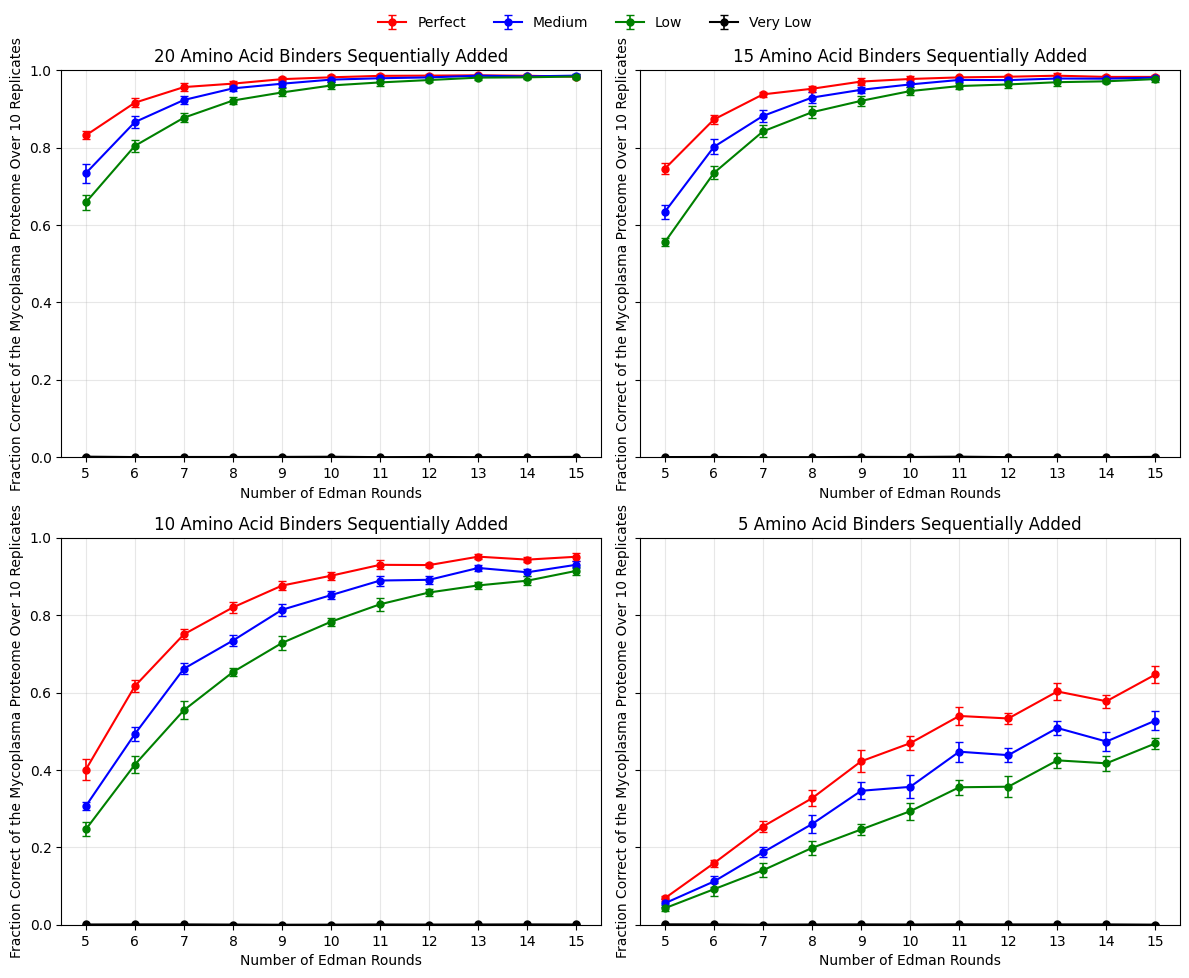

In [5]:
'''
Plot the results from the batch run (Figure 7D).
'''

import pandas as pd
import matplotlib.pyplot as plt
import textwrap

def wrap_ylabel(ax, text, width=40):
    """Wrap y-axis label text to fit within axis height."""
    ax.set_ylabel("\n".join(textwrap.wrap(text, width)))

SUMMARY_CSV = "test/outputs/summary.csv"
n_proteins_mycoplasma = 483

df = pd.read_csv(SUMMARY_CSV)

# format is sample_size, round, binder, specificity, no_error, correct, false_positive, uncertain

df["round_numeric"] = df["round"].astype(str).str.rstrip("r").astype(int)
df["specificity_norm"] = df["specificity"].astype(str).str.strip().str.lower()
df["binder_norm"] = df["binder"].astype(str).str.strip().str.lower()

# fraction correct
df["fraction_correct"] = df["correct"].astype(float) / float(n_proteins_mycoplasma)

# aggregate mean/std over 10 replicates
agg = (
    df.groupby(["binder_norm", "specificity_norm", "round_numeric"], as_index=False)
      .agg(mean_fraction=("fraction_correct", "mean"),
           std_fraction=("fraction_correct", "std"))
)

# Map binders to panel positions and titles
binder_order = [
    ("20aas", "20 Amino Acid Binders Sequentially Added"),
    ("15aas", "15 Amino Acid Binders Sequentially Added"),
    ("10aas", "10 Amino Acid Binders Sequentially Added"),
    ("5aas",  "5 Amino Acid Binders Sequentially Added"),
]

# color mapping
color_map = {
    "perfect": "red",
    "medium":  "blue",
    "low":     "green",
    "verylow": "black",
}

spec_order = ["perfect", "medium", "low", "verylow"]  # legend order

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, (binder_key, title) in zip(axes, binder_order):
    sub = agg[agg["binder_norm"] == binder_key]
    if sub.empty:
        ax.set_title(title)
        ax.set_xlabel("Number of Edman Rounds")
        wrap_ylabel(ax, "Fraction False Positive of the Mycoplasma Proteome Over 10 Replicates", width=30)
        ax.grid(True, alpha=0.3)
        continue

    # one line per specificity
    handles = []
    labels = []
    for spec in spec_order:
        ssub = sub[sub["specificity_norm"] == spec]
        if ssub.empty:
            continue
        ssub = ssub.sort_values("round_numeric")
        color = color_map.get(spec, "gray")
        h = ax.errorbar(
            ssub["round_numeric"],
            ssub["mean_fraction"],
            yerr=ssub["std_fraction"].fillna(0.0),
            fmt="o-",
            linewidth=1.5,
            markersize=5,
            color=color,
            ecolor=color,
            elinewidth=1.2,
            capsize=3,
            label=spec.capitalize() if spec != "verylow" else "Very Low",
        )
        handles.append(h)
        labels.append(h.get_label())

    ax.set_title(title)
    ax.set_xlabel("Number of Edman Rounds")
    ax.set_ylabel("Fraction Correct of the Mycoplasma Proteome Over 10 Replicates")
    ax.set_xticks(sorted(sub["round_numeric"].unique()))
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

# single legend
all_handles, all_labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in all_labels:
            all_handles.append(hh)
            all_labels.append(ll)
            

fig.legend(all_handles, all_labels, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.98))
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Part 2: Supplementary Figures

### Supplementary Figure 15

In [ ]:
import sys, runpy, csv, os
from pathlib import Path
from datetime import datetime

# ----- Modifiable -----
proteome_number = 232273
round_str       = "15r"
sample_sizes    = ["1", "10", "100", "1k", "10k"]
n_iters         = 10
script_path     = "samplereference/Sample.py"
output_dir      = Path("samplereference/data")
proteome_path   = f"preprocessing/proteomes/protein-data-{proteome_number}.json"
# ----------------------

param_path = (
    "samplereference/sample_params_myco.json"
    if proteome_number == 243273
    else "samplereference/sample_params.json"
)
output_dir.mkdir(parents=True, exist_ok=True)

plots_dir   = Path("plots"); plots_dir.mkdir(parents=True, exist_ok=True)
summary_csv = plots_dir / f"{proteome_number}/sample_size_plot_data.csv"

# helper: derive the CSV your script produces
def result_csv(round_str: str, sample_size: str) -> Path:
    return output_dir / f"{round_str}{sample_size}.csv"

# helper: count rows (excluding header)
def count_unique_fragments(csv_path: Path) -> int:
    if not csv_path.exists():
        return 0
    with csv_path.open("r", newline="") as f:
        r = csv.reader(f)
        _ = next(r, None)  # header
        return sum(1 for _ in r)

# helper: remove all non-CSV files in output_dir
def clean_output_dir(keep_csv: Path):
    for item in output_dir.iterdir():
        if item.is_file() and item != keep_csv:
            try:
                item.unlink()
                print(f"🗑️ deleted {item}")
            except Exception as e:
                print(f"⚠️ could not delete {item}: {e}")
        elif item.is_dir():
            # remove directories recursively
            try:
                import shutil
                shutil.rmtree(item)
                print(f"🗑️ deleted directory {item}")
            except Exception as e:
                print(f"⚠️ could not delete directory {item}: {e}")

# write header once
if not summary_csv.exists():
    with summary_csv.open("w", newline="") as f:
        csv.writer(f).writerow(["timestamp","round","sample_size","iteration","unique_fragments"])

# main loop
for ss in sample_sizes:
    for it in range(1, n_iters+1):
        sys.argv = [
            script_path,
            "--sample_size", ss,
            "--round", round_str,
            "--output", str(output_dir),
            "--param_path", param_path,
            "--proteome_path", proteome_path,
        ]

        # run your sample generator (with multiprocessing intact)
        runpy.run_path(script_path, run_name="__main__")

        # identify the CSV the script just wrote
        out_csv = result_csv(round_str, ss)
        uniq = count_unique_fragments(out_csv)

        # clean up all other files
        clean_output_dir(out_csv)

        # append stats
        with summary_csv.open("a", newline="") as f:
            csv.writer(f).writerow([datetime.now().isoformat(timespec="seconds"), round_str, ss, it, uniq])

        print(f"[{round_str}] size={ss}, iter={it}: unique_fragments={uniq}")

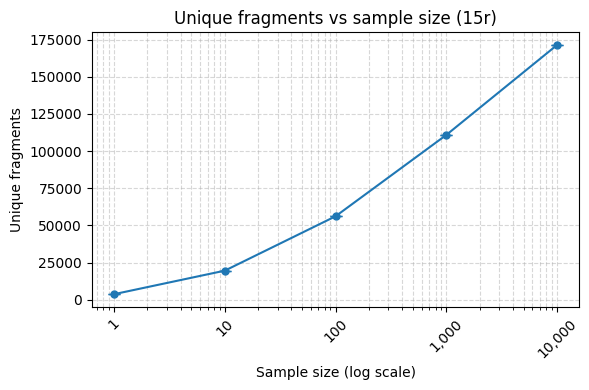

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load data ---
proteome_number = 243273  # or whatever your ID is
df = pd.read_csv(f"plots/{proteome_number}/sample_size_plot_data.csv")

# --- Convert sample_size to numeric (handles "1k", "10k", etc.) ---
def parse_sample_size(x):
    if isinstance(x, str):
        x = x.lower().strip()
        if x.endswith("k"):
            return int(float(x[:-1]) * 1000)
        elif x.endswith("m"):
            return int(float(x[:-1]) * 1_000_000)
    return int(x)

df["sample_size"] = df["sample_size"].apply(parse_sample_size)

# --- Aggregate statistics ---
agg = (
    df.groupby(["round", "sample_size"], sort=False)["unique_fragments"]
      .agg(["mean", "std"])
      .reset_index()
)

# --- Plot ---
round_label = agg["round"].iloc[0]
plt.figure(figsize=(6, 4))

plt.errorbar(
    agg["sample_size"],
    agg["mean"],
    yerr=agg["std"],
    fmt="o-",
    capsize=4,
    elinewidth=1,
    markersize=5
)

plt.xscale("log")  # ensures spacing reflects numeric magnitude
plt.xlabel("Sample size (log scale)")
plt.ylabel("Unique fragments")
plt.title(f"Unique fragments vs sample size ({round_label})")
plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.xticks(agg["sample_size"], [f"{x:,}" for x in agg["sample_size"]], rotation=45)
plt.tight_layout()
plt.show()

### Supplementary Figure 16: Optimal Concentrations and Wash Times

Very High Specificity: Probability of On-Target Binding = 0.91; Probability of Off-Target Binding = 0.00; Difference: 0.91
High Specificity: Probability of On-Target Binding = 0.91; Probability of Off-Target Binding = 0.00; Difference: 0.91
Medium Specificity: Probability of On-Target Binding = 0.91; Probability of Off-Target Binding = 0.00; Difference: 0.91
Low Specificity: Probability of On-Target Binding = 0.91; Probability of Off-Target Binding = 0.01; Difference: 0.90
Very Low Specificity: Probability of On-Target Binding = 0.91; Probability of Off-Target Binding = 0.64; Difference: 0.28


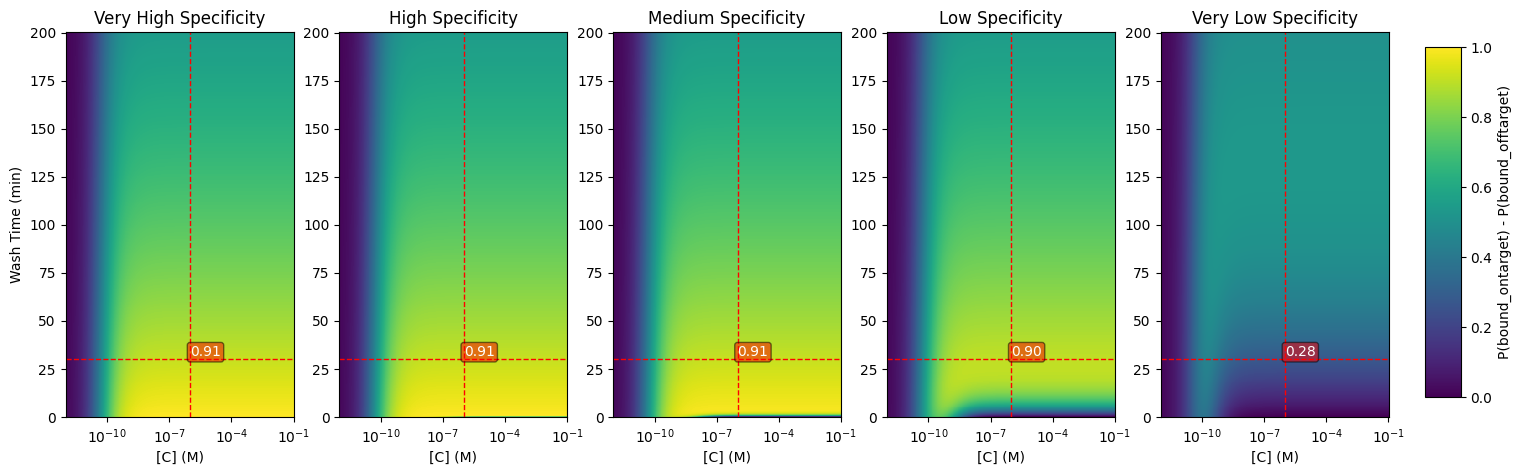

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define concentration and wash time ranges
C_values = np.logspace(-12, -1, 500)  # [C] from 10^-12 to 10^-1 M
t_wash_values = np.linspace(0.1, 200, 400)  # wash time from 0.1 to 120 min
t_wash_sec = t_wash_values * 60  # convert to seconds

# Constants
kon = 1e6  # M^-1 s^-1 (assumed constant)
Kd_on_target = 50e-12  # 50 pM
koff_on_target = 5e-5  # s^-1

# Specificity scenarios: koff_off_target varies, kon is constant → Kd_off_target varies
specificities = {
    "Very High": 2.5,
    "High": 0.25,
    "Medium": 2.5e-2,
    "Low": 2.5e-3,
    "Very Low": 2.5e-4
}

# Meshgrid for plotting
C_mesh, t_mesh = np.meshgrid(C_values, t_wash_sec)

# Setup figure and axes
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
vmin, vmax = 0, 1  # Color scale range

# Plot for each specificity
for ax, (label, koff_off_target) in zip(axes, specificities.items()):
    # Compute corresponding Kd for off-target
    Kd_off_target = koff_off_target / kon

    # Binding probabilities
    p_on = (C_mesh / (C_mesh + Kd_on_target)) * np.exp(-koff_on_target * t_mesh)
    p_off = (C_mesh / (C_mesh + Kd_off_target)) * np.exp(-koff_off_target * t_mesh)
    p_diff = p_on - p_off

    # Plot
    pcm = ax.pcolormesh(C_mesh, t_mesh / 60, p_diff, shading='auto',
                        cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_xscale('log')
    ax.set_title(f'{label} Specificity')
    ax.set_xlabel('[C] (M)')
    # only set first y-axis label
    if ax == axes[0]:
        ax.set_ylabel('Wash Time (min)')
    ax.yaxis.set_tick_params(labelleft=True)  # Force all y-tick labels

    # draw red dotted line at 30 minutes
    ax.axhline(y=30, color='red', linestyle='--', linewidth=1)

    # draw red dotted line at 1 uM
    ax.axvline(x=1e-6, color='red', linestyle='--', linewidth=1)

    # label the intersection point of the two lines with value of p_diff at that point
    C_intersect = 1e-6
    t_intersect = 30 * 60  # in seconds
    p_on_intersect = (C_intersect / (C_intersect + Kd_on_target)) * np.exp(-koff_on_target * t_intersect)
    p_off_intersect = (C_intersect / (C_intersect + Kd_off_target)) * np.exp(-koff_off_target * t_intersect)
    p_diff_intersect = p_on_intersect - p_off_intersect
    ax.text(1e-6, 30, f'{p_diff_intersect:.2f}', color='white',
            fontsize=10, ha='left', va='bottom',
            bbox=dict(facecolor='red', alpha=0.5, boxstyle='round,pad=0.2'))

    print(f"{label} Specificity: Probability of On-Target Binding = {p_on_intersect:.2f}; Probability of Off-Target Binding = {p_off_intersect:.2f}; Difference: {p_diff_intersect:.2f}")

    # save on-target binding probability, off-target binding probability into csv file in test/parameters
    os.makedirs("test/parameters", exist_ok=True)
    # header, and then one row with three values, comma separated
    with open(f"test/parameters/binding_probabilities.csv", "a") as f:
        # only write header if file is empty
        if os.stat("test/parameters/binding_probabilities.csv").st_size == 0:
            f.write("label,on_target_bound,on_target_unbound,off_target_bound,off_target_unbound,difference\n")
        f.write(f"{label},{p_on_intersect:.5f},{1 - p_on_intersect:.5f},{p_off_intersect:.5f},{1 - p_off_intersect:.5f},{p_diff_intersect:.5f}\n")

# Shared colorbar
fig.subplots_adjust(right=0.86)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cbar_ax, label='P(bound_ontarget) - P(bound_offtarget)')

plt.show()

# save plot as png
fig.savefig("plots/binding_probability_difference.png", dpi=300, bbox_inches='tight')

### Supplementary Figure 18

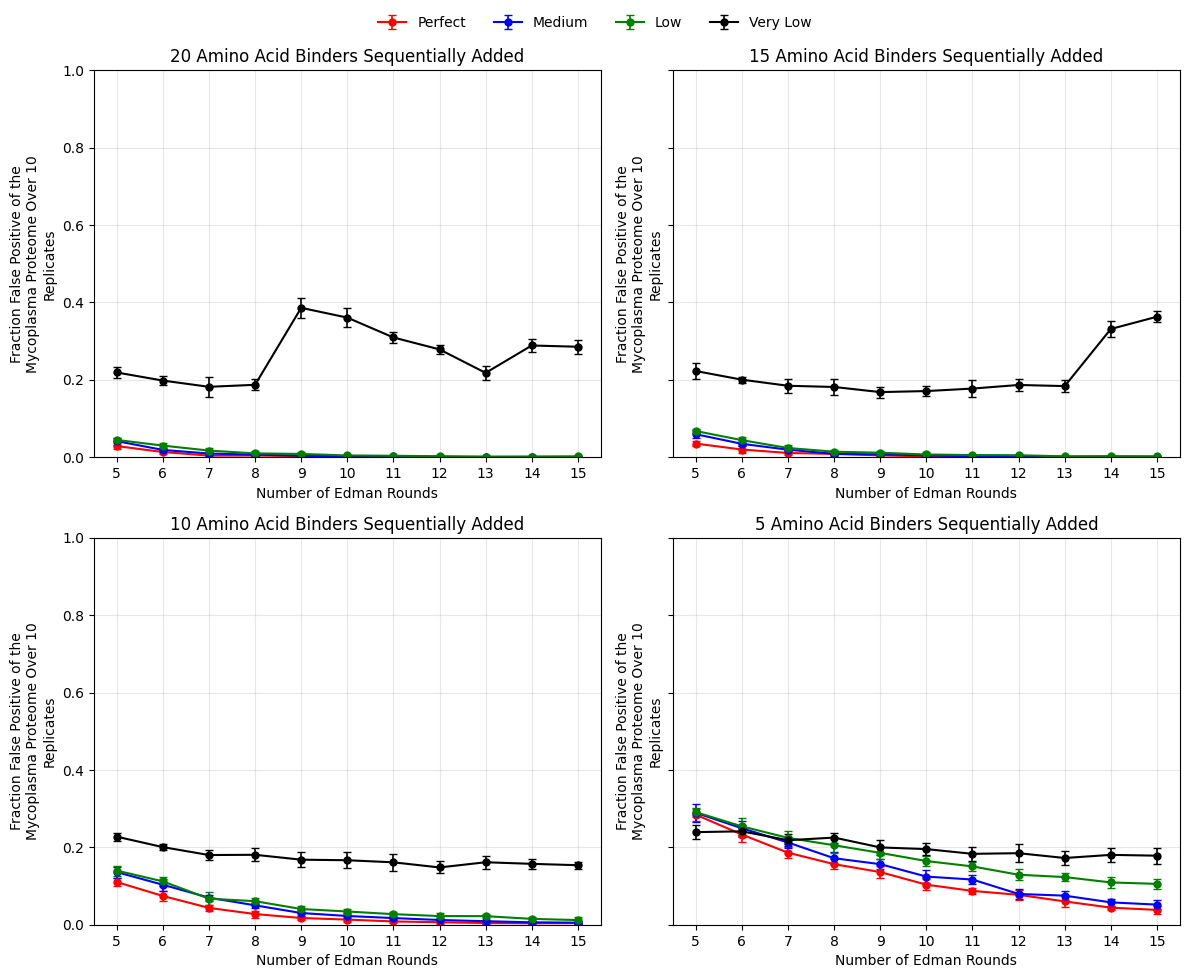

In [3]:
'''
Plot the results from the batch run (Figure 7D).
'''

import pandas as pd
import matplotlib.pyplot as plt
import textwrap

def wrap_ylabel(ax, text, width=40):
    """Wrap y-axis label text to fit within axis height."""
    ax.set_ylabel("\n".join(textwrap.wrap(text, width)))

SUMMARY_CSV = "test/outputs/summary.csv"
n_proteins_mycoplasma = 483

df = pd.read_csv(SUMMARY_CSV)

# format is sample_size, round, binder, specificity, no_error, correct, false_positive, uncertain

df["round_numeric"] = df["round"].astype(str).str.rstrip("r").astype(int)
df["specificity_norm"] = df["specificity"].astype(str).str.strip().str.lower()
df["binder_norm"] = df["binder"].astype(str).str.strip().str.lower()

# fraction false positive
df["fraction_false_positive"] = df["false_positive"].astype(float) / float(n_proteins_mycoplasma)

# aggregate mean/std over 10 replicates
agg = (
    df.groupby(["binder_norm", "specificity_norm", "round_numeric"], as_index=False)
      .agg(mean_fraction=("fraction_false_positive", "mean"),
           std_fraction=("fraction_false_positive", "std"))
)

# Map binders to panel positions and titles
binder_order = [
    ("20aas", "20 Amino Acid Binders Sequentially Added"),
    ("15aas", "15 Amino Acid Binders Sequentially Added"),
    ("10aas", "10 Amino Acid Binders Sequentially Added"),
    ("5aas",  "5 Amino Acid Binders Sequentially Added"),
]

# color mapping
color_map = {
    "perfect": "red",
    "medium":  "blue",
    "low":     "green",
    "verylow": "black",
}

spec_order = ["perfect", "medium", "low", "verylow"]  # legend order

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, (binder_key, title) in zip(axes, binder_order):
    sub = agg[agg["binder_norm"] == binder_key]
    if sub.empty:
        ax.set_title(title)
        ax.set_xlabel("Number of Edman Rounds")
        wrap_ylabel(ax, "Fraction False Positive of the Mycoplasma Proteome Over 10 Replicates", width=30)
        ax.grid(True, alpha=0.3)
        continue

    # one line per specificity
    handles = []
    labels = []
    for spec in spec_order:
        ssub = sub[sub["specificity_norm"] == spec]
        if ssub.empty:
            continue
        ssub = ssub.sort_values("round_numeric")
        color = color_map.get(spec, "gray")
        h = ax.errorbar(
            ssub["round_numeric"],
            ssub["mean_fraction"],
            yerr=ssub["std_fraction"].fillna(0.0),
            fmt="o-",
            linewidth=1.5,
            markersize=5,
            color=color,
            ecolor=color,
            elinewidth=1.2,
            capsize=3,
            label=spec.capitalize() if spec != "verylow" else "Very Low",
        )
        handles.append(h)
        labels.append(h.get_label())

    ax.set_title(title)
    ax.set_xlabel("Number of Edman Rounds")
    wrap_ylabel(ax, "Fraction False Positive of the Mycoplasma Proteome Over 10 Replicates", width=30)
    ax.set_xticks(sorted(sub["round_numeric"].unique()))
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

# single legend
all_handles, all_labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in all_labels:
            all_handles.append(hh)
            all_labels.append(ll)

fig.legend(all_handles, all_labels, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.98))
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() 
